# A simple example of U-Net network for PyTorch

(3, 192, 192, 3)
0 255
(3, 6, 192, 192)
0.0 1.0


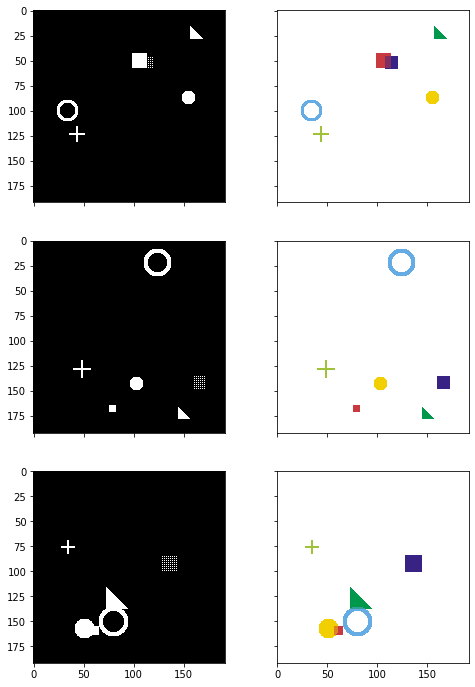

In [1]:
%matplotlib inline

import os,sys
# os.environ["CUDA_VISIBLE_DEVICES"] = "1"
sys.path.append('..')

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import helper as helper
import simulation as simulation

# Generate some random images
input_images, target_masks = simulation.generate_random_data(192, 192, count=3)

for x in [input_images, target_masks]:
    print(x.shape)
    print(x.min(), x.max())

# Change channel-order and make 3 channels for matplot
# input_images_rgb = [(x.swapaxes(0, 2).swapaxes(0,1) * -255 + 255).astype(np.uint8) for x in input_images]
input_images_rgb = [x.astype(np.uint8) for x in input_images]

# Map each channel (i.e. class) to each color
target_masks_rgb = [helper.masks_to_colorimg(x) for x in target_masks]

# Left: Input image, Right: Target mask
helper.plot_side_by_side([input_images_rgb, target_masks_rgb])

In [2]:
from torchvision import models

base_model = models.resnet18(pretrained=True)

def find_last_layer(layer):
    children = list(layer.children())
    if len(children) == 0:
        return layer
    else:
        return find_last_layer(children[-1])

list(base_model.children())

[Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False),
 BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
 ReLU(inplace=True),
 MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False),
 Sequential(
   (0): BasicBlock(
     (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
     (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (relu): ReLU(inplace=True)
     (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
     (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   )
   (1): BasicBlock(
     (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
     (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (relu): ReLU(inplace=True)
     (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), pad

In [3]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torch.nn as nn

class SimDataset(Dataset):
    def __init__(self, count, transform=None):
        super().__init__()

        self.input_images, self.target_masks = simulation.generate_random_data(
            192, 192, count=count)
        self.transform = transform

    def __len__(self):
        return len(self.input_images)

    def __getitem__(self, index):
        image = self.input_images[index]
        mask = self.target_masks[index]

        if self.transform:
            image = self.transform(image)

        return [image, mask]

# use same transform for train/val for this example 
trans = transforms.Compose([
    transforms.ToTensor(),
])

train_set = SimDataset(2000, transform=trans)
val_set = SimDataset(200, transform=trans)

image_datasets = {
    'train': train_set, 'val': val_set
}

batch_size = 25

dataloaders = {
    'train': DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=0),
    'val': DataLoader(val_set, batch_size=batch_size, shuffle=True, num_workers=0)
}

dataset_sizes = {
    x: len(image_datasets[x]) for x in image_datasets.keys()
}

dataset_sizes

{'train': 2000, 'val': 200}

torch.Size([25, 3, 192, 192]) torch.Size([25, 6, 192, 192])
0.0 1.0 0.021717666 0.14576009
0.0 1.0 0.0046310765 0.06789431


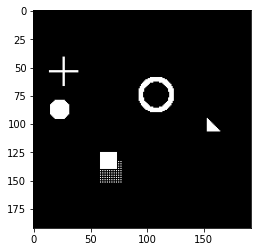

In [4]:
def reverse_transform(inp):
    inp = inp.numpy().transpose((1,2,0))
    inp = np.clip(inp, 0, 1)
    inp = (inp * 255).astype(np.uint8)

    return inp

# get a batch of training data 
inputs, masks = next(iter(dataloaders['train']))

print(inputs.shape, masks.shape)
for x in [inputs.numpy(), masks.numpy()]:
    print(x.min(), x.max(), x.mean(), x.std())

plt.imshow(reverse_transform(inputs[0]))

In [5]:
# define FCN structure

class FCN(nn.Module):

    def __init__(self, n_class):
        super().__init__()

        self.base_model = models.resnet18(pretrained=True)

        layers = list(base_model.children())
        self.layer1 = nn.Sequential(*layers[:5]) # size=(N, 64, x.H/2, x.W/2)
        self.upsample1 = nn.Upsample(scale_factor=4, mode='bilinear')
        self.layer2 = layers[5]  # size=(N, 128, x.H/4, x.W/4)
        self.upsample2 = nn.Upsample(scale_factor=8, mode='bilinear')
        self.layer3 = layers[6]  # size=(N, 256, x.H/8, x.W/8)
        self.upsample3 = nn.Upsample(scale_factor=16, mode='bilinear')
        self.layer4 = layers[7]  # size=(N, 512, x.H/16, x.W/16)
        self.upsample4 = nn.Upsample(scale_factor=32, mode='bilinear')
        
        self.conv1k = nn.Conv2d(64 + 128 + 256 + 512, n_class, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.layer1(x)
        up1 = self.upsample1(x)
        x = self.layer2(x)
        up2 = self.upsample2(x)
        x = self.layer3(x)
        up3 = self.upsample3(x)
        x = self.layer4(x)
        up4 = self.upsample4(x)
        
        merge = torch.cat([up1, up2, up3, up4], dim=1)
        merge = self.conv1k(merge)
        out = self.sigmoid(merge)
        
        return out

In [6]:
from torchinfo import summary
import torch

FCN_model = FCN(6).cuda()

summary(FCN_model, input_size=(15, 3, 224, 224))

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:3635: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


Layer (type:depth-idx)                        Output Shape              Param #
FCN                                           --                        --
├─ResNet: 1-1                                 --                        --
│    └─Conv2d: 2-1                            --                        9,408
│    └─BatchNorm2d: 2-2                       --                        128
│    └─ReLU: 2-3                              --                        --
│    └─MaxPool2d: 2-4                         --                        --
│    └─Sequential: 2-5                        --                        --
│    │    └─BasicBlock: 3-1                   --                        73,984
│    │    └─BasicBlock: 3-2                   --                        73,984
│    └─Sequential: 2-6                        --                        --
│    │    └─BasicBlock: 3-3                   --                        230,144
│    │    └─BasicBlock: 3-4                   --                        295,42

In [7]:
from utils.utils import tensor2var

def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = 1e10

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                for param_group in optimizer.param_groups:
                    print('LR', param_group['lr'])

                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            batch_size = 10
            epoch_steps = 10
            for inputs, labels in dataloaders[phase]:
                inputs = tensor2var(inputs)
                labels = tensor2var(labels)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)

            epoch_loss = running_loss / (batch_size * epoch_steps)

            print('{} Loss: {:.4f}'.format(
                phase, epoch_loss))

            # deep copy the model
            if phase == 'val' and epoch_loss < best_loss:
                best_loss = epoch_loss
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val loss: {:4f}'.format(best_loss))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import time
import copy



device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model_ft = FCN(6).to(device)

criterion = nn.BCELoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
LR 0.001


/opt/conda/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:134: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


train Loss: 3.0935
val Loss: 0.0902

Epoch 1/24
----------
LR 0.001
train Loss: 0.7658
val Loss: 0.0713

Epoch 2/24
----------
LR 0.001
train Loss: 0.6681
val Loss: 0.0649

Epoch 3/24
----------
LR 0.001
train Loss: 0.6221
val Loss: 0.0615

Epoch 4/24
----------
LR 0.001
train Loss: 0.5913
val Loss: 0.0587

Epoch 5/24
----------
LR 0.001
train Loss: 0.5686
val Loss: 0.0566

Epoch 6/24
----------
LR 0.0001
train Loss: 0.5572
val Loss: 0.0565

Epoch 7/24
----------
LR 0.0001
train Loss: 0.5555
val Loss: 0.0562

Epoch 8/24
----------
LR 0.0001
train Loss: 0.5536
val Loss: 0.0562

Epoch 9/24
----------
LR 0.0001
train Loss: 0.5520
val Loss: 0.0560

Epoch 10/24
----------
LR 0.0001
train Loss: 0.5502
val Loss: 0.0558

Epoch 11/24
----------
LR 0.0001
train Loss: 0.5487
val Loss: 0.0557

Epoch 12/24
----------
LR 0.0001
train Loss: 0.5467
val Loss: 0.0555

Epoch 13/24
----------
LR 1e-05
train Loss: 0.5464
val Loss: 0.0553

Epoch 14/24
----------
LR 1e-05
train Loss: 0.5455
val Loss: 0.0554


torch.Size([3, 6, 192, 192])


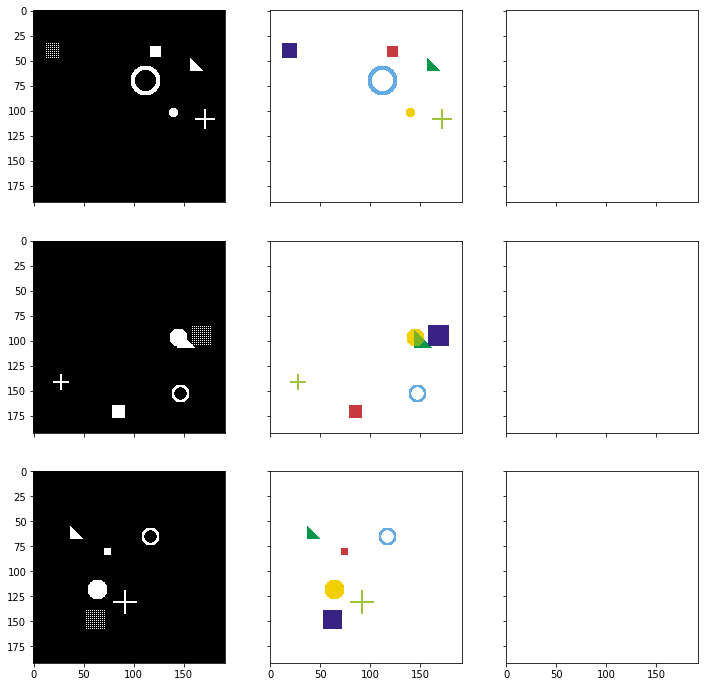

In [10]:
# prediction 

model_ft.eval() # set model to evaluate mode 

test_dataset = SimDataset(3, transform=trans)
test_loader = DataLoader(test_dataset, batch_size=3, shuffle=False, num_workers=0)

inputs, labels = next(iter(test_loader))
inputs = tensor2var(inputs)
labels = tensor2var(labels)

pred = model_ft(inputs)
print(pred.shape)

# change channel-order and make 3 channels for matplot 
input_images_rgb = [reverse_transform(x) for x in inputs.cpu()]

# Map each channel (i.e. class) to each color 
target_masks_rgb = [helper.masks_to_colorimg(x) for x in labels.cpu()]
pred_rgb = [helper.masks_to_colorimg(x) for x in pred.cpu()]

helper.plot_side_by_side([input_images_rgb, target_masks_rgb, pred_rgb])
